# Load Package

In [ ]:
pip install node2vec

In [ ]:
import pandas as pd
import numpy as np
import os
import networkx as nx
from node2vec import Node2Vec
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
%matplotlib inline
from sklearn.manifold import TSNE

# Load Data and Explore

In [ ]:
df = pd.read_csv("nw_kor.csv")
#df = pd.read_csv("Data/networkanalysis_cum.csv")

In [ ]:
df.rename(columns = {'author':'Usernames'}, inplace = True)

In [ ]:
view=df.groupby(['Celebrity','Usernames']).size().reset_index(name='Freq')
#view

In [ ]:
a=["Celebrity","Usernames"]
data = view[a]
#data = df[a]
data.shape

(49274, 2)

In [ ]:
piecount = data.Celebrity.value_counts()
piecount = pd.DataFrame(piecount)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


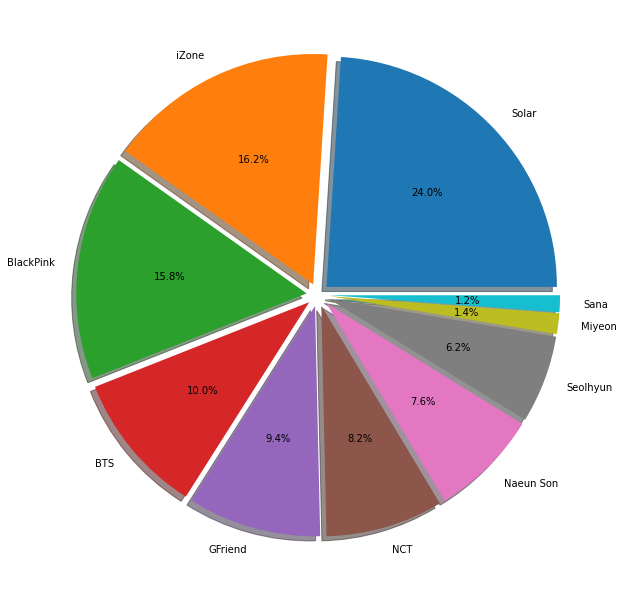

In [ ]:
labels=piecount.index
explode = []
for k in piecount.index:
    explode.append(0.05)
plt.pie(piecount.values, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%')
plt.subplots_adjust(left=2, bottom=2, right=4, top=4)
plt.show()

In [ ]:
print(*data.Celebrity.unique(),sep="\n")

BTS
BlackPink
GFriend
Miyeon
NCT
Naeun Son
Sana
Seolhyun
Solar
iZone


In [ ]:
data.shape

(49274, 2)

In [ ]:
print("Number of Celebrities: %0.0f" %len(data.Celebrity.unique()))
print("Number of Users: %0.0f" %len(data.Usernames.unique()))

Number of Celebrities: 10
Number of Users: 35147


In [ ]:
print("The percentage of unique values: {:.2%}".format(len(data.Usernames.unique())/len(data.Usernames)))

The percentage of unique values: 71.33%


# Generate Adjacency Matrix

In [ ]:
df_merge = data.merge(data, on='Usernames')
results = pd.crosstab(df_merge.Celebrity_x, df_merge.Celebrity_y)
np.fill_diagonal(results.values, 0)
network_table=results
network_table

Celebrity_y,BTS,BlackPink,GFriend,Miyeon,NCT,Naeun Son,Sana,Seolhyun,Solar,iZone
Celebrity_x,,,,,,,,,,
BTS,0,689,682,59,412,448,8,380,602,431
BlackPink,689,0,924,137,687,640,52,414,674,646
GFriend,682,924,0,139,521,780,26,877,1196,1403
Miyeon,59,137,139,0,0,161,11,106,155,222
NCT,412,687,521,0,0,402,0,371,703,625
Naeun Son,448,640,780,161,402,0,10,822,938,950
Sana,8,52,26,11,0,10,0,10,18,12
Seolhyun,380,414,877,106,371,822,10,0,1437,1140
Solar,602,674,1196,155,703,938,18,1437,0,3414


# Fit NetworkX

In [ ]:
#graph=nx.from_numpy_matrix(np_matrix)
graph=nx.from_pandas_adjacency(network_table)
graph.name = "Case Study for Korean Influencers"
print(nx.info(graph))

Name: Case Study for Korean Influencers
Type: Graph
Number of nodes: 10
Number of edges: 43
Average degree:   8.6000


''

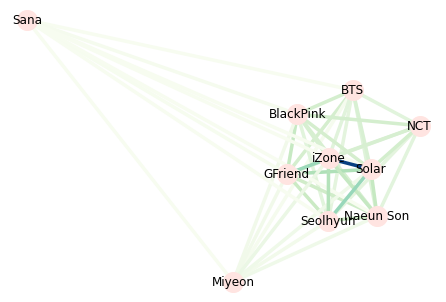

In [ ]:
edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())
pos=nx.spring_layout(graph,scale=4)
nx.draw(graph,
                 #pos,
                 with_labels=True,
                 node_size=400,
                 node_color="mistyrose",
                 edgelist=edges, 
                 edge_color=weights,
                 edge_cmap=plt.cm.GnBu,
                 style="solid",
                 width=3.5)


In [ ]:
vector_size = round(df.shape[0]**0.25)
vector_size

16

In [ ]:
%%time
setup = Node2Vec(graph,dimensions=vector_size, walk_length=15, num_walks=18)
model = setup.fit(window=3, min_count=1, sg=1)

Generating walks (CPU: 1): 100%|██████████| 18/18 [00:00<00:00, 147.40it/s]


CPU times: user 168 ms, sys: 4.88 ms, total: 173 ms
Wall time: 188 ms


In [ ]:
#vocab, vectors = model.wv.key_to_index, model.wv.get_normed_vectors()
vocab, vectors = model.wv.vocab, model.wv.vectors

# get node name and embedding vector index.
name_index = np.array([(v[0], v[1].index) for v in vocab.items()]) #.index

# init dataframe using embedding vectors and set index as node name
node2vec_output = pd.DataFrame(vectors[name_index[:,1].astype(int)])
node2vec_output.index = name_index[:,0]

In [ ]:
model.wv.most_similar("BlackPink",topn=10)

[('Solar', 0.9966571927070618),
 ('iZone', 0.996224582195282),
 ('GFriend', 0.9955752491950989),
 ('BTS', 0.9939093589782715),
 ('Naeun Son', 0.9935728907585144),
 ('Seolhyun', 0.9929853677749634),
 ('Miyeon', 0.9906546473503113),
 ('NCT', 0.9857029318809509),
 ('Sana', 0.9538063406944275)]

In [ ]:
node2vec_output.shape

(10, 16)

In [ ]:
#node2vec_output.to_csv("node2vec_k3.csv")

# K-means: find "K"

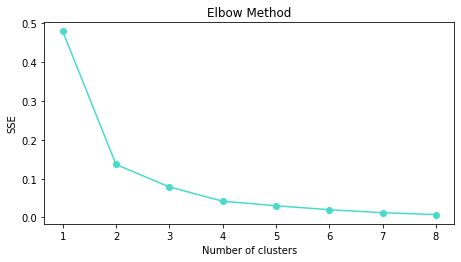

In [ ]:
SSE = []
for i in range(1,(len(node2vec_output.index)-1)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=50, random_state=42)
    kmeans.fit(node2vec_output)
    SSE.append(kmeans.inertia_)
plt.plot(range(1,(len(node2vec_output.index)-1)), SSE,"o-",color="#47DBCD")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.subplots_adjust(left=0.25, bottom=0.8, right=1.2, top=1.5)
plt.show()

## K-means: training and subsampling

In [ ]:
n_clusters=3

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=50, random_state=42)

In [ ]:
kmeans.fit(node2vec_output)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

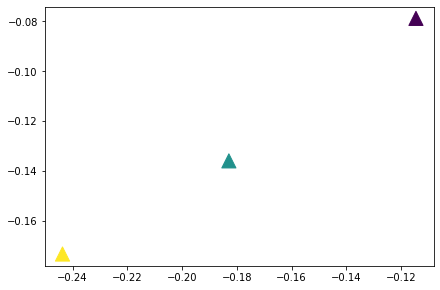

In [ ]:
t = np.arange(n_clusters)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c=t,marker="^")
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1)

In [ ]:
subsample=[]
for i in range(kmeans.n_clusters):
  temp = []
  temp=node2vec_output.iloc[kmeans.labels_==i,:]
  subsample.append(temp)

In [ ]:
for list in range(len(subsample)):
  print("Group",list+1)
  print(subsample[list])
  print("--------------------------------------------------------------")

Group 1
              0         1         2   ...        13        14        15
Sana   -0.089618 -0.071649 -0.003039  ... -0.043400 -0.102120  0.014032
NCT    -0.109779 -0.097330  0.032881  ... -0.048294 -0.241587  0.031689
Miyeon -0.144210 -0.067727  0.037089  ... -0.058805 -0.197231 -0.010469

[3 rows x 16 columns]
--------------------------------------------------------------
Group 2
                 0         1         2   ...        13        14        15
BTS       -0.186073 -0.159345  0.043289  ... -0.118391 -0.346044  0.027395
BlackPink -0.186074 -0.117281  0.071182  ... -0.112053 -0.334396 -0.008005
Naeun Son -0.139308 -0.119381  0.069812  ... -0.106206 -0.317578 -0.010998
Seolhyun  -0.220078 -0.148290  0.036138  ... -0.085400 -0.346950  0.023048

[4 rows x 16 columns]
--------------------------------------------------------------
Group 3
               0         1         2   ...        13        14        15
GFriend -0.234220 -0.147478  0.064113  ... -0.101717 -0.409747 -0.00

# TSNE plot

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=1.5, n_components=2, learning_rate=75, init='pca', n_iter=5000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


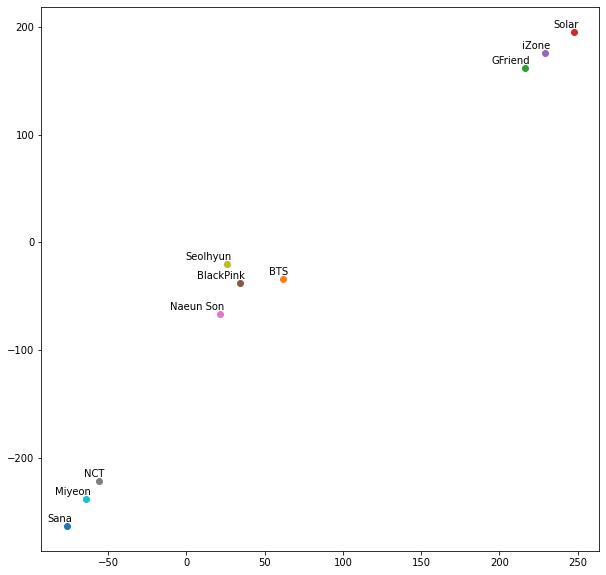

In [ ]:
tsne_plot(model)